## Tutorial 7: Building an earthquake catalogue

In this demonstration we will show how to automatically build an earthquake catalogue using SeisBench and the GaMMA associator with OBS data to create an earthquake catalog from raw waveforms. We will use example data from the [YH](https://ds.iris.edu/gmap/#network=YH&starttime=2014-01-01&endtime=2015-06-01&planet=earth) network from the HOBITSS deployment in 2014-2015.

First, we import the seisbench and gamma packages, as well as other required packages and modules to import data and make plots.

In [13]:
# SeisBench models
import seisbench.models as sbm

# GaMMA associator
from gamma.utils import association

# ObsPy classes
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Stream

# Other ancillary packages
from pyproj import CRS, Transformer
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

### Configuration

The following code cells contain all configurations. The first cell configures the local coordinate projection. In this case, we use a transverse mercator projection for New Zealand, as we will be using data from northern New Zealand. 

In [31]:
# Projections
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(27291)  # NZGD49 / North Island Grid: https://epsg.io/27291#google_vignette
transformer = Transformer.from_crs(wgs84, local_crs)

The second, third and fourth cells configure the gamma associator. Please see it's documentation for details.

In [40]:
# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']

# Use dbscan to cut a long sequence of picks into segments to speed up associaiton using small windows.
config["use_dbscan"] = False
config["use_amplitude"] = False

# 
config["x(km)"] = (100, 600)
config["y(km)"] = (250, 500)
config["z(km)"] = (0, 150)

# Average crustal P- and S-wave velocities
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}  
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

In [41]:
# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)

# The maximum time between two picks for one to be considered as a neighbor of the other. See details in DBSCAN
config["dbscan_eps"] = 25  # seconds

# The number of samples in a neighborhood for a point to be considered as a core point. See details in DBSCAN
config["dbscan_min_samples"] = 3

In [42]:
# Filtering
# Minimum picks per earthquake
config["min_picks_per_eq"] = 5

# Max phase time residual (s)
config["max_sigma11"] = 2.0

# Max phase amplitude residual (in log scale)
config["max_sigma22"] = 1.0

# Max covariance term. (Usually not used)
config["max_sigma12"] = 1.0

### Download data

We download waveform data for 1 hour from the YH network offshore northern New Zealand (HOBITSS deployment). We use October 2, 2014, which corresponds to a magnitude [4.6 earthquake](https://www.geonet.org.nz/earthquake/technical/2014p742742) in the vicinity of the HOBITSS deployment. Therefore, we expect to detect low-magnitude aftershocks in this region.

In [17]:
# Initialize the FDSN client
client = Client()

# Start time in UTC, 33 minutes before the mainshock
t0 = UTCDateTime("2014-10-02T19:33:00")

# End time, 1 hour later
t1 = t0 + 60 * 60

# Get waveform data
stream = client.get_waveforms(network="YH", station="*", location="*", channel="?H?", starttime=t0, endtime=t1)

# Get station metadata
inv = client.get_stations(network="YH", station="*", location="*", channel="?H?", starttime=t0, endtime=t1)

KeyboardInterrupt: 

### Annotate waveforms

For this example, we use OBSTransformer model. However, in principle any picker could be used for obtaining the picks with only minimal changes. 

> Warning: This will take some time and requires sufficient main memory. If you are short on memory, reduce the study time in the cell before.

In [10]:
# Load the pre-trained OBSTransformer model weights
picker = sbm.OBSTransformer.from_pretrained('obst2024')

# We tuned the thresholds a bit - Feel free to play around with these values
picks = picker.classify(stream, batch_size=256, P_threshold=0.075, S_threshold=0.1).picks

# Output number of P and S picks
Counter([p.phase for p in picks])

Counter({'S': 462, 'P': 254})

We now convert the picks and station metadata into pandas dataframes in the format required for the GaMMA associator.

In [11]:
# Initialize empty list and fill it with pick info
pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })

# Store it into a DataFrame
pick_df = pd.DataFrame(pick_df)

# Initialize empty list and fill it with station info
station_df = []
for station in inv[0]:
    station_df.append({
        "id": f"CX.{station.code}.",
        "longitude": station.longitude,
        "latitude": station.latitude,
        "elevation(m)": station.elevation
    })

# Store it as a DataFrame
station_df = pd.DataFrame(station_df)

# Convert map coordinates to km
station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = - station_df["elevation(m)"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df["y(km)"])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df["x(km)"], station_df["y(km)"])}

Let's have a look at the picks generated by the model. Note that we retained the probabilities from the deep learning model. It will be used by the associator later on.

In [12]:
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
304,YH.LOBS6.,2014-10-02 19:00:42.440,0.783968,s
528,YH.LOBS1.,2014-10-02 19:00:43.530,0.888389,p
686,YH.LOBS9.,2014-10-02 19:00:49.290,0.082427,p
80,YH.EBS3.,2014-10-02 19:00:58.530,0.783073,s
367,YH.LOBS7.,2014-10-02 19:00:58.570,0.793940,s
...,...,...,...,...
685,YH.LOBS8.,2014-10-02 19:59:50.600,0.324481,s
715,YH.LOBS9.,2014-10-02 19:59:52.140,0.558031,s
403,YH.LOBS7.,2014-10-02 19:59:52.440,0.576025,s
117,YH.EBS3.,2014-10-02 19:59:53.630,0.123908,s


### GaMMA association

We now run the phase association. This will take a moment. We convert the output into two dataframes, one for the catalogue and one for the assignment of picks to the catalog.

In [43]:
catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])

In [44]:
catalog

""


In [16]:
station_df

,id,longitude,latitude,elevation(m),x(km),y(km),z(km)
0,CX.EBS1.,178.678894,-38.745899,-995.0,602.248675,425.386103,0.9950
1,CX.EBS2.,178.583496,-38.777100,-930.0,593.048005,421.907577,0.9300
2,CX.EBS3.,178.650604,-38.694599,-1023.0,599.772604,431.709259,1.0230
3,CX.EBS4.,178.819901,-38.688801,-1712.0,615.911153,431.844059,1.7120
4,CX.EBS5.,178.325699,-38.994400,-1348.0,567.724070,396.311103,1.3480
5,CX.LOB10.,178.313202,-39.133301,-1444.0,566.017455,379.479537,1.4440
6,CX.LOBS1.,178.818695,-38.592098,-993.6,616.221569,443.592503,0.9936
7,CX.LOBS2.,179.046097,-38.620998,-3562.5,637.761020,439.271652,3.5625
8,CX.LOBS3.,179.147293,-38.792198,-3540.3,646.574376,418.099934,3.5403
9,CX.LOBS4.,178.981506,-39.120098,-3440.5,629.292594,378.889577,3.4405


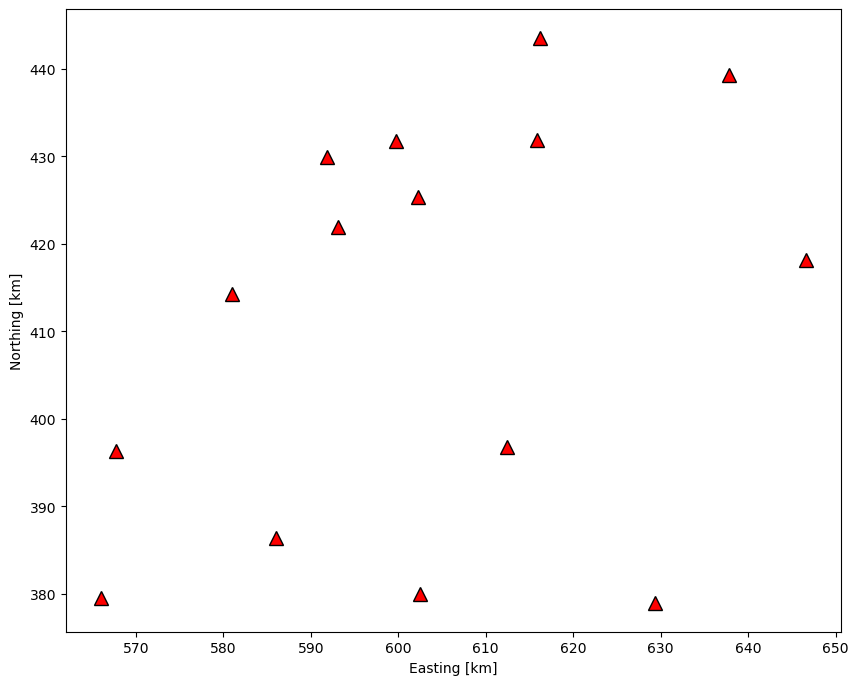

In [39]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
# cb = ax.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=8, cmap="viridis")
# cbar = fig.colorbar(cb)
# cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
# cbar.set_label("Depth[km]")

ax.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
# ax.set_xlim(100, 500)
# ax.set_ylim(375, 450)
plt.show()

In [ ]:
event_idx = np.random.choice(catalog["event_index"])
event_picks = [picks[i] for i in assignments[assignments["event_idx"] == event_idx]["pick_idx"]]
event = catalog[catalog["event_index"] == event_idx].iloc[0]

first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

sub = obspy.Stream()

for station in np.unique([pick.trace_id for pick in event_picks]):
    sub.append(stream.select(station=station[3:-1], channel="HHZ")[0])

sub = sub.slice(first - 5, last + 5)

sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))
    station_x, station_y = station_dict[trace.id[:-4]]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    ax.plot(trace.times(), 10 * normed + y)
    
for pick in event_picks:
    station_x, station_y = station_dict[pick.trace_id]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    x = pick.peak_time - trace.stats.starttime
    if pick.phase == "P":
        ls = '-'
    else:
        ls = '--'
    ax.plot([x, x], [y - 10, y + 10], 'k', ls=ls)
    
ax.set_ylim(0)
ax.set_xlim(0, np.max(trace.times()))
ax.set_ylabel("Hypocentral distance [km]")
ax.set_xlabel("Time [s]")

print("Event information")
print(event)